In [ ]:
# Import necessary libraries
import sys, os, glob, time, imageio
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image

import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [ ]:
# Root directory for dataset in Google Drive
google_drive_root = '/Users/rishuraj7581gmail.com/Downloads/chest_xray'  # Replace with your folder structure
dataroot_train = os.path.join(google_drive_root, 'chest_xray', 'train')
dataroot_test = os.path.join(google_drive_root, 'chest_xray', 'test')
dataroot_val = os.path.join(google_drive_root, 'chest_xray', 'val')

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0


Image has 1 channel


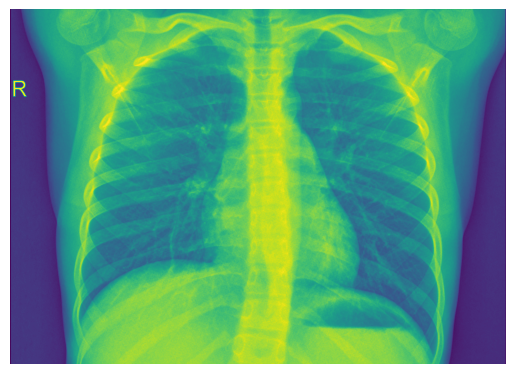

In [ ]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

from PIL import Image
import numpy as np
import os

# Update filename with the path in Google Drive
filename = '/Users/rishuraj7581gmail.com/Downloads/chest_xray/test/NORMAL/IM-0003-0001.jpeg'  # Replace with your folder structure

# Check if the file exists
if not os.path.exists(filename):
    raise FileNotFoundError(f"File not found: {filename}")

# Open image using PIL
im = Image.open(filename)
im.show()

# Convert to numpy array
img = np.array(im)

# Find number of channels
if img.ndim == 2:
    channels = 1
    print("Image has 1 channel")
else:
    channels = img.shape[-1]  # Corrected from 'image' to 'img'
    print("Image has", channels, "channels")

# Display the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename))
plt.axis('off')
plt.show()


In [ ]:
# Define the datasets
dataset_train = dset.ImageFolder(root=dataroot_train,
                                 is_valid_file=check_Image,
                                 transform=transforms.Compose([
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5), (0.5)),
                                 ]))

dataset_test = dset.ImageFolder(root=dataroot_test,
                                is_valid_file=check_Image,
                                transform=transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5)),
                                ]))

dataset_val = dset.ImageFolder(root=dataroot_val,
                               is_valid_file=check_Image,
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5), (0.5)),
                               ]))

# Combine datasets
l = []
l.append(dataset_train)
l.append(dataset_test)
l.append(dataset_val)
image_datasets = torch.utils.data.ConcatDataset(l)

# Create dataloader
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


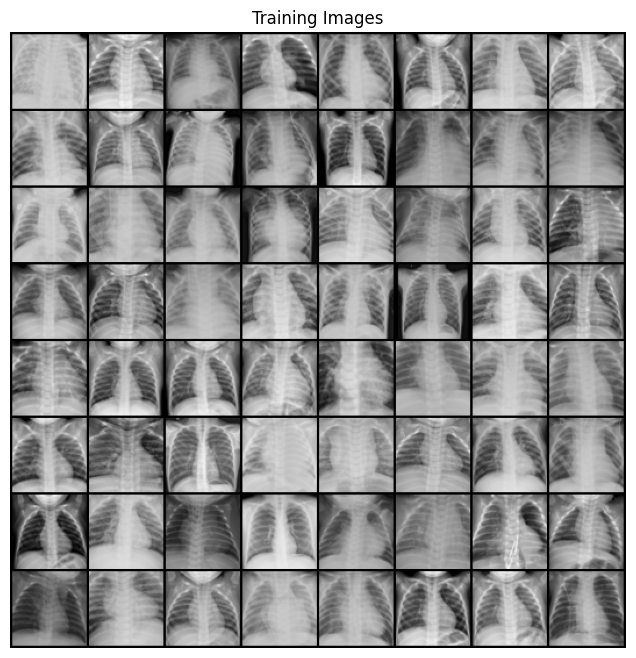

In [ ]:
# Visualize some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [ ]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
# DCGAN Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_model = nn.Sequential(
            # Input: Z latent vector
            nn.ConvTranspose2d(in_channels = SIZE_OF_NOISE,
                               out_channels = SIZE_OF_FEATURE_MAP * 8,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP * 8),
            nn.ReLU(True),  # Changed from LeakyReLU to ReLU

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP * 8,
                               out_channels = SIZE_OF_FEATURE_MAP * 4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP * 4),
            nn.ReLU(True),  # Changed from LeakyReLU to ReLU

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP * 4,
                               out_channels = SIZE_OF_FEATURE_MAP * 2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP * 2),
            nn.ReLU(True),  # Changed from LeakyReLU to ReLU

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP * 2,
                               out_channels = SIZE_OF_FEATURE_MAP,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = SIZE_OF_FEATURE_MAP),
            nn.ReLU(True),  # Changed from LeakyReLU to ReLU

            nn.ConvTranspose2d(in_channels = SIZE_OF_FEATURE_MAP,
                               out_channels = NUM_CHANNELS,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        return self.seq_model(inputs)


In [ ]:
# Define constants for DCGAN
SIZE_OF_NOISE = 100
SIZE_OF_FEATURE_MAP = 64
NUM_CHANNELS = 1

# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the Generator model
print(netG)


Generator(
  (seq_model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
# DCGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the Discriminator model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torch_fidelity import calculate_metrics

# Function to compute PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Function to compute SSIM
def calculate_ssim(img1, img2):
    img1 = img1.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to Numpy (BCHW to BHWC)
    img2 = img2.cpu().numpy().transpose(0, 2, 3, 1)

    ssim_values = []
    for i in range(img1.shape[0]):
        height, width, _ = img1[i].shape
        min_dim = min(height, width)
        win_size = min(7, min_dim) if min_dim >= 3 else 3  # Ensure a minimum of 3x3 window

        ssim_val = ssim(
            img1[i],
            img2[i],
            win_size=win_size,
            data_range=1.0,   # Assuming pixel values are normalized to [0, 1]
            channel_axis=-1   # Explicitly set the axis for color channels
        )
        ssim_values.append(ssim_val)

    return np.mean(ssim_values)

# Function to compute FID
def calculate_fid_score(real_images, fake_images):
    """
    Calculate the FID score between real and fake images using torch_fidelity.

    Parameters:
        real_images (torch.Tensor): Real images (B, C, H, W) normalized to [0, 1].
        fake_images (torch.Tensor): Fake images (B, C, H, W) normalized to [0, 1].

    Returns:
        float: The FID score.
    """
    real_images = (real_images * 255).byte()  # Convert to [0, 255] range
    fake_images = (fake_images * 255).byte()

    # Save real and fake images as temporary folders
    import tempfile
    from torchvision.utils import save_image

    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:
        # Save images to their respective folders
        for i, img in enumerate(real_images):
            save_image(img.float() / 255.0, f"{real_dir}/real_{i}.png")
        for i, img in enumerate(fake_images):
            save_image(img.float() / 255.0, f"{fake_dir}/fake_{i}.png")

        # Calculate FID using the saved folders
        metrics = calculate_metrics(
            input1=real_dir,
            input2=fake_dir,
            cuda=torch.cuda.is_available(),
            fid=True  # Enable FID computation
        )
    return metrics["frechet_inception_distance"]


In [ ]:
# Initialize lists to track metrics
fid_scores = []
psnr_scores = []
ssim_scores = []

img_list = []
G_losses = []
D_losses = []
iters = 0


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                real_images = data[0].cpu()

            min_batch_size = min(real_images.size(0), fake.size(0))
            real_images = real_images[:min_batch_size]
            fake = fake[:min_batch_size]
            # Calculate PSNR
            psnr_score = calculate_psnr(real_images, fake)
            psnr_scores.append(psnr_score)

            # Calculate SSIM
            ssim_score = calculate_ssim(real_images, fake)
            ssim_scores.append(ssim_score)

            # Calculate FID
            fid_score = calculate_fid_score(real_images, fake)
            fid_scores.append(fid_score)

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



Starting Training Loop...
[0/50][0/92]	Loss_D: 1.3980	Loss_G: 3.3033	D(x): 0.7240	D(G(z)): 0.5952 / 0.0499


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpv5dwdjua" with extensions png,jpg,jpeg
Found 64 samples
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and Un

[0/50][50/92]	Loss_D: 0.0333	Loss_G: 8.0639	D(x): 0.9922	D(G(z)): 0.0242 / 0.0004
[1/50][0/92]	Loss_D: 0.0192	Loss_G: 9.3034	D(x): 0.9979	D(G(z)): 0.0166 / 0.0002
[1/50][50/92]	Loss_D: 0.8391	Loss_G: 12.0106	D(x): 0.6713	D(G(z)): 0.0004 / 0.0000
[2/50][0/92]	Loss_D: 0.1716	Loss_G: 3.9586	D(x): 0.9207	D(G(z)): 0.0615 / 0.0368
[2/50][50/92]	Loss_D: 0.2381	Loss_G: 7.1964	D(x): 0.9580	D(G(z)): 0.1628 / 0.0013
[3/50][0/92]	Loss_D: 0.3651	Loss_G: 6.7724	D(x): 0.9399	D(G(z)): 0.2333 / 0.0023
[3/50][50/92]	Loss_D: 0.5612	Loss_G: 7.2046	D(x): 0.9922	D(G(z)): 0.3460 / 0.0020
[4/50][0/92]	Loss_D: 0.1758	Loss_G: 5.2774	D(x): 0.9015	D(G(z)): 0.0588 / 0.0131
[4/50][50/92]	Loss_D: 0.3067	Loss_G: 2.7797	D(x): 0.8094	D(G(z)): 0.0462 / 0.0831
[5/50][0/92]	Loss_D: 0.7654	Loss_G: 7.0751	D(x): 0.9252	D(G(z)): 0.4410 / 0.0023


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmp7td4ym5_" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[5/50][50/92]	Loss_D: 0.4686	Loss_G: 5.5801	D(x): 0.9386	D(G(z)): 0.3001 / 0.0084
[6/50][0/92]	Loss_D: 0.1987	Loss_G: 3.2432	D(x): 0.8782	D(G(z)): 0.0465 / 0.0816
[6/50][50/92]	Loss_D: 0.2162	Loss_G: 7.4869	D(x): 0.8566	D(G(z)): 0.0090 / 0.0033
[7/50][0/92]	Loss_D: 0.2303	Loss_G: 3.9177	D(x): 0.8940	D(G(z)): 0.0938 / 0.0352
[7/50][50/92]	Loss_D: 0.1701	Loss_G: 5.8350	D(x): 0.8989	D(G(z)): 0.0426 / 0.0072
[8/50][0/92]	Loss_D: 0.1973	Loss_G: 4.5126	D(x): 0.9157	D(G(z)): 0.0867 / 0.0311
[8/50][50/92]	Loss_D: 0.3815	Loss_G: 2.9708	D(x): 0.7759	D(G(z)): 0.0448 / 0.0891
[9/50][0/92]	Loss_D: 1.1117	Loss_G: 12.6871	D(x): 0.9846	D(G(z)): 0.6144 / 0.0002
[9/50][50/92]	Loss_D: 0.1681	Loss_G: 4.1475	D(x): 0.9565	D(G(z)): 0.1047 / 0.0383
[10/50][0/92]	Loss_D: 0.3357	Loss_G: 4.9452	D(x): 0.9325	D(G(z)): 0.2022 / 0.0163
[10/50][50/92]	Loss_D: 0.2968	Loss_G: 6.1846	D(x): 0.9669	D(G(z)): 0.2085 / 0.0076


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpj9b4qin4" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[11/50][0/92]	Loss_D: 0.2580	Loss_G: 3.7522	D(x): 0.8527	D(G(z)): 0.0537 / 0.0403
[11/50][50/92]	Loss_D: 0.1950	Loss_G: 4.5359	D(x): 0.8786	D(G(z)): 0.0405 / 0.0197
[12/50][0/92]	Loss_D: 0.3424	Loss_G: 4.3656	D(x): 0.8060	D(G(z)): 0.0371 / 0.0692
[12/50][50/92]	Loss_D: 0.2578	Loss_G: 3.7364	D(x): 0.8763	D(G(z)): 0.0630 / 0.0429
[13/50][0/92]	Loss_D: 0.1870	Loss_G: 4.4214	D(x): 0.9163	D(G(z)): 0.0853 / 0.0274
[13/50][50/92]	Loss_D: 0.0932	Loss_G: 4.2417	D(x): 0.9736	D(G(z)): 0.0569 / 0.0435
[14/50][0/92]	Loss_D: 0.3051	Loss_G: 3.9466	D(x): 0.8533	D(G(z)): 0.0943 / 0.0381
[14/50][50/92]	Loss_D: 0.2541	Loss_G: 4.6381	D(x): 0.8488	D(G(z)): 0.0554 / 0.0222
[15/50][0/92]	Loss_D: 0.2386	Loss_G: 4.6706	D(x): 0.9498	D(G(z)): 0.1515 / 0.0179
[15/50][50/92]	Loss_D: 0.1045	Loss_G: 8.9456	D(x): 0.9150	D(G(z)): 0.0058 / 0.0030
[16/50][0/92]	Loss_D: 0.2251	Loss_G: 6.9187	D(x): 0.9685	D(G(z)): 0.1605 / 0.0035


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmp54wyfnk4" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[16/50][50/92]	Loss_D: 0.0832	Loss_G: 5.7241	D(x): 0.9577	D(G(z)): 0.0310 / 0.0230
[17/50][0/92]	Loss_D: 0.2510	Loss_G: 4.8288	D(x): 0.9369	D(G(z)): 0.1513 / 0.0140
[17/50][50/92]	Loss_D: 0.1193	Loss_G: 4.5746	D(x): 0.9366	D(G(z)): 0.0481 / 0.0181
[18/50][0/92]	Loss_D: 0.3063	Loss_G: 7.0845	D(x): 0.9747	D(G(z)): 0.2122 / 0.0065
[18/50][50/92]	Loss_D: 0.1206	Loss_G: 4.2838	D(x): 0.9767	D(G(z)): 0.0873 / 0.0227
[19/50][0/92]	Loss_D: 0.2184	Loss_G: 7.2558	D(x): 0.9789	D(G(z)): 0.1584 / 0.0019
[19/50][50/92]	Loss_D: 0.0905	Loss_G: 6.9490	D(x): 0.9863	D(G(z)): 0.0686 / 0.0026
[20/50][0/92]	Loss_D: 0.5375	Loss_G: 2.5398	D(x): 0.6873	D(G(z)): 0.0407 / 0.1708
[20/50][50/92]	Loss_D: 0.1600	Loss_G: 5.2307	D(x): 0.9317	D(G(z)): 0.0745 / 0.0103
[21/50][0/92]	Loss_D: 0.2408	Loss_G: 5.3470	D(x): 0.9379	D(G(z)): 0.1408 / 0.0096
[21/50][50/92]	Loss_D: 0.1498	Loss_G: 5.7533	D(x): 0.9759	D(G(z)): 0.1129 / 0.0067


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpoha1ysgh" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[22/50][0/92]	Loss_D: 0.2204	Loss_G: 5.2621	D(x): 0.9666	D(G(z)): 0.1541 / 0.0140
[22/50][50/92]	Loss_D: 0.1734	Loss_G: 3.4903	D(x): 0.8959	D(G(z)): 0.0431 / 0.0451
[23/50][0/92]	Loss_D: 0.0875	Loss_G: 5.7097	D(x): 0.9755	D(G(z)): 0.0574 / 0.0066
[23/50][50/92]	Loss_D: 0.1586	Loss_G: 4.6623	D(x): 0.9011	D(G(z)): 0.0375 / 0.0242
[24/50][0/92]	Loss_D: 0.3944	Loss_G: 2.5968	D(x): 0.7524	D(G(z)): 0.0226 / 0.1219
[24/50][50/92]	Loss_D: 0.1824	Loss_G: 6.0119	D(x): 0.9881	D(G(z)): 0.1378 / 0.0047
[25/50][0/92]	Loss_D: 0.1776	Loss_G: 6.0850	D(x): 0.9441	D(G(z)): 0.0954 / 0.0071
[25/50][50/92]	Loss_D: 0.2230	Loss_G: 5.4301	D(x): 0.9347	D(G(z)): 0.1317 / 0.0085
[26/50][0/92]	Loss_D: 0.1053	Loss_G: 4.8911	D(x): 0.9558	D(G(z)): 0.0530 / 0.0132
[26/50][50/92]	Loss_D: 0.1701	Loss_G: 4.0799	D(x): 0.8968	D(G(z)): 0.0409 / 0.0282
[27/50][0/92]	Loss_D: 0.5674	Loss_G: 12.4357	D(x): 0.9874	D(G(z)): 0.3635 / 0.0004


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmp1s2vf90c" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[27/50][50/92]	Loss_D: 0.2912	Loss_G: 6.6057	D(x): 0.9347	D(G(z)): 0.1617 / 0.0103
[28/50][0/92]	Loss_D: 0.1288	Loss_G: 4.6333	D(x): 0.9574	D(G(z)): 0.0731 / 0.0200
[28/50][50/92]	Loss_D: 0.3297	Loss_G: 3.1105	D(x): 0.8088	D(G(z)): 0.0186 / 0.0801
[29/50][0/92]	Loss_D: 0.1263	Loss_G: 5.6152	D(x): 0.9404	D(G(z)): 0.0368 / 0.0085
[29/50][50/92]	Loss_D: 0.1841	Loss_G: 5.7724	D(x): 0.8612	D(G(z)): 0.0190 / 0.0289
[30/50][0/92]	Loss_D: 0.2847	Loss_G: 7.4564	D(x): 0.9896	D(G(z)): 0.1984 / 0.0060
[30/50][50/92]	Loss_D: 0.1660	Loss_G: 5.3629	D(x): 0.9493	D(G(z)): 0.0942 / 0.0122
[31/50][0/92]	Loss_D: 0.1140	Loss_G: 6.0778	D(x): 0.9466	D(G(z)): 0.0429 / 0.0067
[31/50][50/92]	Loss_D: 0.1823	Loss_G: 5.5444	D(x): 0.9594	D(G(z)): 0.1153 / 0.0089
[32/50][0/92]	Loss_D: 0.1923	Loss_G: 4.9503	D(x): 0.9190	D(G(z)): 0.0875 / 0.0250
[32/50][50/92]	Loss_D: 0.1404	Loss_G: 4.5372	D(x): 0.9558	D(G(z)): 0.0812 / 0.0179


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpgmymz_ee" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[33/50][0/92]	Loss_D: 0.1707	Loss_G: 8.6542	D(x): 0.8950	D(G(z)): 0.0200 / 0.0062
[33/50][50/92]	Loss_D: 0.1890	Loss_G: 4.6200	D(x): 0.8950	D(G(z)): 0.0562 / 0.0345
[34/50][0/92]	Loss_D: 0.2645	Loss_G: 5.9597	D(x): 0.8131	D(G(z)): 0.0069 / 0.0176
[34/50][50/92]	Loss_D: 0.2868	Loss_G: 5.6607	D(x): 0.9288	D(G(z)): 0.1612 / 0.0162
[35/50][0/92]	Loss_D: 0.2973	Loss_G: 7.2539	D(x): 0.9211	D(G(z)): 0.1422 / 0.0048
[35/50][50/92]	Loss_D: 0.0706	Loss_G: 6.4411	D(x): 0.9683	D(G(z)): 0.0337 / 0.0057
[36/50][0/92]	Loss_D: 0.2010	Loss_G: 3.8398	D(x): 0.8713	D(G(z)): 0.0401 / 0.0360
[36/50][50/92]	Loss_D: 0.4834	Loss_G: 11.7795	D(x): 0.9826	D(G(z)): 0.3103 / 0.0003
[37/50][0/92]	Loss_D: 0.5005	Loss_G: 5.0509	D(x): 0.7298	D(G(z)): 0.0052 / 0.0225
[37/50][50/92]	Loss_D: 0.1545	Loss_G: 4.9143	D(x): 0.9934	D(G(z)): 0.1119 / 0.0199
[38/50][0/92]	Loss_D: 0.5548	Loss_G: 12.0952	D(x): 0.9694	D(G(z)): 0.3512 / 0.0001


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmp4zr3hq6m" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[38/50][50/92]	Loss_D: 0.0974	Loss_G: 5.0289	D(x): 0.9363	D(G(z)): 0.0239 / 0.0136
[39/50][0/92]	Loss_D: 0.1532	Loss_G: 5.8115	D(x): 0.9675	D(G(z)): 0.1024 / 0.0070
[39/50][50/92]	Loss_D: 0.1896	Loss_G: 5.2694	D(x): 0.9320	D(G(z)): 0.0985 / 0.0118
[40/50][0/92]	Loss_D: 0.2155	Loss_G: 3.8928	D(x): 0.8601	D(G(z)): 0.0328 / 0.0386
[40/50][50/92]	Loss_D: 0.1014	Loss_G: 5.0318	D(x): 0.9313	D(G(z)): 0.0191 / 0.0156
[41/50][0/92]	Loss_D: 0.0879	Loss_G: 5.3367	D(x): 0.9682	D(G(z)): 0.0505 / 0.0107
[41/50][50/92]	Loss_D: 0.1327	Loss_G: 5.3331	D(x): 0.9671	D(G(z)): 0.0855 / 0.0102
[42/50][0/92]	Loss_D: 0.1945	Loss_G: 4.6853	D(x): 0.8547	D(G(z)): 0.0134 / 0.0342
[42/50][50/92]	Loss_D: 0.3039	Loss_G: 5.6032	D(x): 0.8490	D(G(z)): 0.0246 / 0.0127
[43/50][0/92]	Loss_D: 0.1385	Loss_G: 7.0508	D(x): 0.8926	D(G(z)): 0.0106 / 0.0022


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpz2ykqo25" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[43/50][50/92]	Loss_D: 0.0586	Loss_G: 5.5899	D(x): 0.9859	D(G(z)): 0.0398 / 0.0183
[44/50][0/92]	Loss_D: 0.1237	Loss_G: 5.1453	D(x): 0.9677	D(G(z)): 0.0802 / 0.0110
[44/50][50/92]	Loss_D: 0.1900	Loss_G: 3.7462	D(x): 0.9243	D(G(z)): 0.0795 / 0.0396
[45/50][0/92]	Loss_D: 0.2234	Loss_G: 6.4690	D(x): 0.9866	D(G(z)): 0.1714 / 0.0053
[45/50][50/92]	Loss_D: 0.1498	Loss_G: 3.9158	D(x): 0.8920	D(G(z)): 0.0228 / 0.0402
[46/50][0/92]	Loss_D: 0.2191	Loss_G: 3.7316	D(x): 0.8579	D(G(z)): 0.0263 / 0.0497
[46/50][50/92]	Loss_D: 0.4018	Loss_G: 4.9525	D(x): 0.7669	D(G(z)): 0.0078 / 0.0168
[47/50][0/92]	Loss_D: 0.2009	Loss_G: 5.0935	D(x): 0.9340	D(G(z)): 0.1092 / 0.0126
[47/50][50/92]	Loss_D: 0.1845	Loss_G: 3.4078	D(x): 0.8859	D(G(z)): 0.0163 / 0.0658
[48/50][0/92]	Loss_D: 0.1126	Loss_G: 4.8052	D(x): 0.9779	D(G(z)): 0.0790 / 0.0186
[48/50][50/92]	Loss_D: 0.0809	Loss_G: 6.0625	D(x): 0.9595	D(G(z)): 0.0281 / 0.0051


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpca4yslja" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

[49/50][0/92]	Loss_D: 0.2289	Loss_G: 3.4063	D(x): 0.8736	D(G(z)): 0.0455 / 0.0567
[49/50][50/92]	Loss_D: 0.0539	Loss_G: 5.4609	D(x): 0.9802	D(G(z)): 0.0319 / 0.0085


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc0000gn/T/tmpgtgvwygy" with extensions png,jpg,jpeg
Found 32 samples
Processing samples:   0%|          | 0/32 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/8w/v1wl9mb945s369d14r97z0rc00

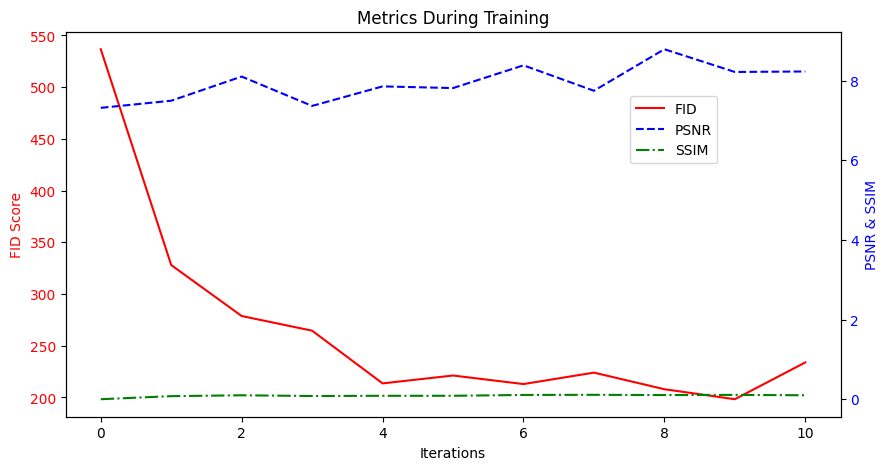

In [ ]:
import matplotlib.pyplot as plt

# Plot FID on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title("Metrics During Training")
ax1.plot(fid_scores, label="FID", color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("FID Score", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create a twin y-axis for PSNR and SSIM
ax2 = ax1.twinx()
ax2.plot(psnr_scores, label="PSNR", color="blue", linestyle="--")
ax2.plot(ssim_scores, label="SSIM", color="green", linestyle="-.")
ax2.set_ylabel("PSNR & SSIM", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both y-axes
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85), bbox_transform=ax1.transAxes)

plt.show()


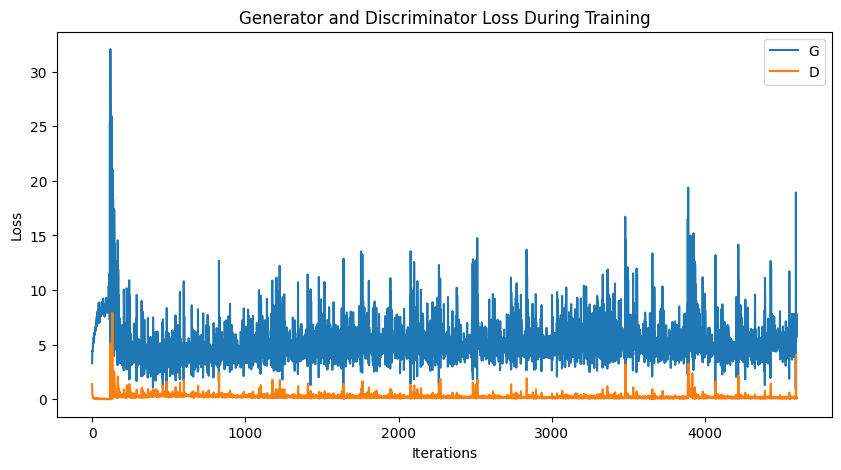

In [ ]:
# Plot Generator and Discriminator Loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


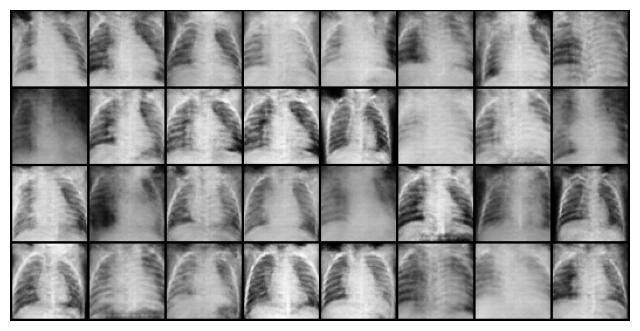

In [ ]:
# Generate and display the animation of generated images
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
